In [7]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [1]:
def load_average_scores():
    rsivl = "/ptmp/tshen/shared/RSIVL/labels.xls"
    visc = "/ptmp/tshen/shared/VISC/VISC-C/labels.csv"

    labels = {}
    labels['rsivl'] = pd.read_excel(rsivl)
    labels['rsivl'].rename(columns={'subjective scores': 'complexity', 'Unnamed: 0': 'filename'}, inplace=True)
    labels['rsivl']['filename'] = labels['rsivl']['filename'] + ".bmp"
    labels['visc'] = pd.read_csv(visc)
    labels['visc'].rename(columns={'score': 'complexity', 'image': 'filename'}, inplace=True)

    for k in labels.keys():
        assert labels[k][['filename', 'complexity']].isnull().values.any() == False

    return labels

In [2]:
def load_predictions(folder="../out/2023July20", filenames=['4points', '8points', '16points', '32points', '64points']):
    rsivl = "{}/RSIVL".format(folder)
    visc = "{}/VISC".format(folder)

    preds = {}
    
    for v, n in zip([rsivl, visc], ["rsivl", "visc"]):
        preds_dataset = []
        single_file_len = 0

        for f in filenames:
            df = pd.read_csv("{}/{}.csv".format(v, f), names=["filename", f], header=None)
            preds_dataset.append(df)
            single_file_len = len(df)

        combined_df = pd.concat([df.set_index("filename") for df in preds_dataset], axis=1, join='inner').reset_index()  # join on filename
        assert len(combined_df) == single_file_len
        assert combined_df.isnull().values.any() == False

        preds[n] = combined_df

    preds['rsivl']['filename'] = preds['rsivl']['filename'].str.replace('.json', '.bmp', regex=False)
    for k in ["visc"]:
        preds[k]['filename'] = preds[k]['filename'].str.replace('.json', '.jpg', regex=False)

    return preds

In [3]:
def load_subject_scores():
    rsivl = "/ptmp/tshen/shared/subject_level_data/rsivl_labels.csv"
    visc = "/ptmp/tshen/shared/subject_level_data/visc_labels.csv"
    visc_participant_ratings = "/ptmp/tshen/shared/subject_level_data/visc_participant_files/"

    labels = {}
    labels['rsivl'] = pd.read_csv(rsivl)
    labels['visc'] = pd.read_csv(visc)

    files = glob.glob(visc_participant_ratings + "*.csv")

    participant_ratings_list = []
    for f in files:
        df = pd.read_csv(f)
        base = os.path.basename(f)
        df = df.rename(columns={"image":"filename", "score": "participant{}".format(os.path.splitext(base)[0])})        
        participant_ratings_list.append(df)

    participant_df = pd.concat([df.set_index('filename') for df in participant_ratings_list], axis=1, join='outer')
    labels['visc'] = pd.concat([labels['visc'].set_index('filename'), participant_df], axis=1, join='outer')
    labels['visc']['filename'] = labels['visc'].index

    return labels

In [4]:
def join_preds_labels(preds, avg_labels, subject_labels):
    data = {}
    
    for k in ["rsivl", "visc"]:
        data[k] = pd.concat(
            [df.set_index("filename") for df in [preds[k], avg_labels[k][['filename', 'complexity']], subject_labels[k]]], 
            axis=1, join='inner').reset_index()

        if k == 'rsivl':
            data[k]['computed_average'] = data[k][['participant{}'.format(i) for i in range(1, 27)]].mean(axis=1)

        elif k == 'visc':
            data[k]['computed_average'] = data[k][['rating{}'.format(i) for i in range(1, 11)]].mean(axis=1)

        if k != 'ic9600':
            assert len(data[k]) == len(preds[k]) == len(avg_labels[k]) == len(subject_labels[k])
        else:
            pass

    assert data['rsivl'].isnull().values.any() == False
    for i in range(1, 41):
        assert data['visc']['participant{}'.format(i)].isna().sum() == (800-200)

    return data

In [5]:
levels = ['4points', '8points', '16points', '32points', '64points']

In [8]:
preds = load_predictions(folder="../out/2023July20", filenames=levels)
avg_labels = load_average_scores()
subject_labels = load_subject_scores()
data = join_preds_labels(preds, avg_labels, subject_labels)


# Remove outliers

In [9]:
data['rsivl'] = data['rsivl'][data['rsivl'].participant1 != -9999]

In [10]:
assert len(data['rsivl']) == 48
assert (data['rsivl'] == -9999).sum(axis=0).sum() == 0

# Correlation between participants and model prediction

In [23]:
correlations = {}

for d in ['rsivl', 'visc']:

    if d == 'rsivl':
        participants = list(range(1, 27))
    elif d == 'visc':
        participants = list(range(1, 41))

    dataset_corr = []
    for i in participants:
        par_pearson = []
        par_spearman = []
        for l in levels:

            if d == 'visc':
                rows = ~data[d]['participant{}'.format(i)].isna()
                x = data[d][rows]['participant{}'.format(i)]
                y = data[d][rows][l]
            else:
                x = data[d]['participant{}'.format(i)]
                y = data[d][l]

            par_pearson.append(stats.pearsonr(x, y).statistic)
            par_spearman.append(stats.spearmanr(x, y).statistic)

        dataset_corr.append(par_pearson + par_spearman)
    
    correlations[d] = pd.DataFrame(dataset_corr, columns=["pearson_{}".format(l) for l in levels]+["spearman_{}".format(l) for l in levels])

In [24]:
correlations['rsivl']

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
0,0.545568,0.664250,0.739209,0.764584,0.742005,0.563815,0.695792,0.789561,0.821660,0.839746
1,0.610161,0.750640,0.809423,0.835083,0.807315,0.612852,0.766571,0.822547,0.853059,0.854711
2,0.605965,0.624015,0.716869,0.651806,0.606632,0.584475,0.645660,0.718293,0.712826,0.699775
3,0.371609,0.537524,0.553869,0.649798,0.636877,0.347431,0.531623,0.564698,0.685483,0.697400
4,0.229157,0.400625,0.486252,0.585597,0.614164,0.254055,0.395746,0.447172,0.541710,0.576191
5,0.434494,0.553757,0.634716,0.698065,0.687450,0.448184,0.562836,0.639317,0.687692,0.698355
6,0.370171,0.536573,0.609861,0.654439,0.646203,0.376283,0.564168,0.638571,0.680657,0.704606
7,0.367824,0.567089,0.648494,0.676960,0.689513,0.332908,0.523939,0.607780,0.641944,0.677241
8,0.358649,0.426158,0.508560,0.553314,0.578125,0.353282,0.433686,0.508595,0.540244,0.578002
9,0.345760,0.480429,0.522173,0.550537,0.568279,0.360277,0.485613,0.533169,0.531965,0.561093


In [26]:
correlations['rsivl'].describe()

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.360646,0.465300,0.531524,0.563760,0.557279,0.366113,0.471751,0.532289,0.569135,0.580253
std,0.206173,0.252029,0.275121,0.283698,0.273016,0.202735,0.253996,0.280787,0.294954,0.298698
min,-0.224178,-0.236578,-0.209312,-0.241108,-0.211013,-0.200923,-0.259536,-0.245145,-0.294622,-0.308982
25%,0.348983,0.427090,0.510346,0.551231,0.570741,0.348300,0.437994,0.512678,0.540611,0.576644
50%,0.389774,0.536351,0.609630,0.650802,0.640965,0.378052,0.536987,0.608839,0.672933,0.691357
75%,0.466400,0.629858,0.703064,0.723725,0.719394,0.497338,0.621180,0.693728,0.726976,0.732691
max,0.610161,0.750640,0.809423,0.835083,0.807315,0.612852,0.766571,0.822547,0.853059,0.854711


In [25]:
correlations['visc']

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
0,-0.000278,0.241306,0.521090,0.604915,0.624532,0.007300,0.220516,0.521435,0.617267,0.644255
1,0.059841,0.193665,0.227565,0.229072,0.187823,0.068083,0.227473,0.243553,0.301781,0.296148
2,0.156590,0.291452,0.396821,0.414301,0.392993,0.201714,0.310519,0.393970,0.403600,0.382857
3,0.172209,0.288492,0.361189,0.359442,0.324567,0.154947,0.290104,0.345146,0.366939,0.369042
4,0.040013,0.216413,0.434324,0.545826,0.585226,0.041061,0.226977,0.450911,0.587364,0.638846
5,0.151724,0.210957,0.282683,0.323614,0.311250,0.162158,0.209899,0.283180,0.331416,0.321192
6,-0.006603,0.054821,0.098133,0.102811,0.109174,-0.045974,0.027287,0.084486,0.105534,0.114654
7,0.048232,0.211396,0.378504,0.448579,0.481003,0.066036,0.193513,0.352883,0.427814,0.476844
8,0.421247,0.629217,0.683002,0.623715,0.571112,0.425774,0.631434,0.702565,0.696159,0.644819
9,-0.117830,0.081373,0.258775,0.328067,0.339520,-0.143405,0.074860,0.231838,0.287286,0.303214


In [27]:
correlations['visc'].describe()

,pearson_4points,pearson_8points,pearson_16points,pearson_32points,pearson_64points,spearman_4points,spearman_8points,spearman_16points,spearman_32points,spearman_64points
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.144661,0.285236,0.405817,0.425318,0.412318,0.142572,0.277598,0.402219,0.441620,0.444050
std,0.220778,0.225139,0.196236,0.169270,0.156581,0.226186,0.228611,0.207305,0.188379,0.173433
min,-0.396420,-0.300033,-0.174606,-0.124272,-0.075333,-0.420220,-0.332303,-0.235004,-0.184168,-0.124403
25%,0.036328,0.186151,0.286537,0.351598,0.323570,0.012061,0.174921,0.283219,0.358058,0.358289
50%,0.133376,0.269132,0.414538,0.446918,0.439722,0.138489,0.267580,0.411381,0.447408,0.456149
75%,0.261487,0.442216,0.553734,0.554747,0.518324,0.257077,0.415710,0.556055,0.593794,0.576029
max,0.691826,0.763548,0.728514,0.653659,0.655062,0.683730,0.754984,0.737387,0.696159,0.678000


# Clustering Participants based on Level Correlations

In [28]:
from sklearn.manifold import TSNE

In [119]:
def run_tsne(X, labels):
    X_manifold = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(X)
    plt.figure()
    plt.scatter(X_manifold[:, 0], X_manifold[:, 1])

    for i, txt in enumerate(labels):
        plt.annotate(txt, (X_manifold[i, 0], X_manifold[i, 1]))

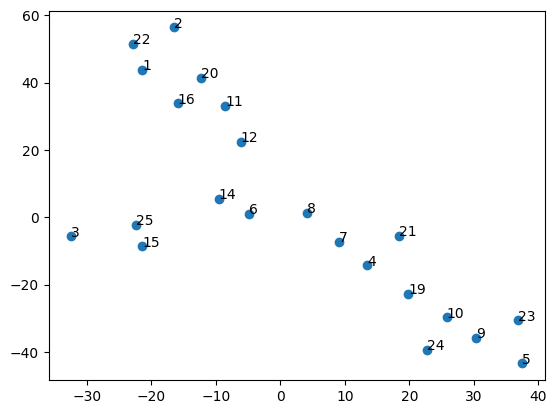

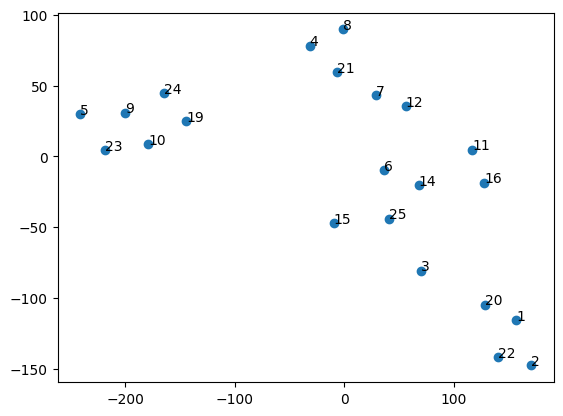

In [123]:
df_no_outliers = correlations['rsivl'][~correlations['rsivl'].index.isin([i-1 for i in [13, 17, 18, 26]])]
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
run_tsne(df_no_outliers[['pearson_{}'.format(l) for l in levels]].to_numpy(), labels=participants)
run_tsne(df_no_outliers[['spearman_{}'.format(l) for l in levels]].to_numpy(), labels=participants)

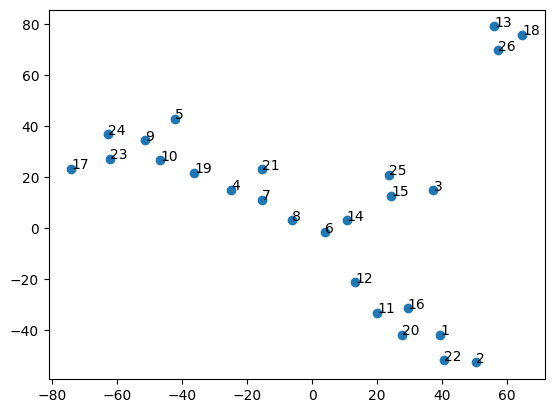

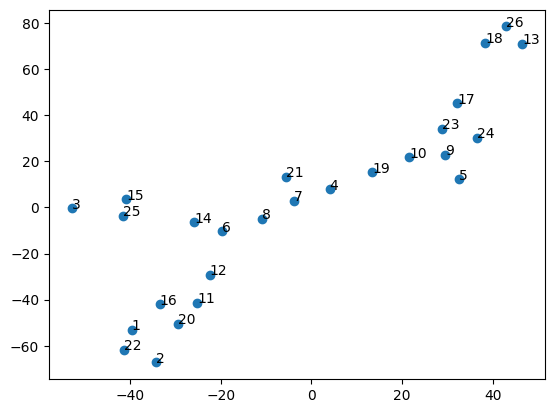

In [124]:
df = correlations['rsivl']
participants = list(range(1, 27))
run_tsne(df[['pearson_{}'.format(l) for l in levels]].to_numpy(), labels=participants)
run_tsne(df[['pearson_{}'.format(l) for l in levels]].to_numpy(), labels=participants)

## Try Diffs

### Without 4 point correlation

In [98]:
df = pd.DataFrame(correlations['rsivl']['pearson_4points'])

for i in range(1, len(levels)):
    df["{}-{}".format(levels[i], levels[i-1])] = correlations['rsivl']['pearson_{}'.format(levels[i])]-correlations['rsivl']['pearson_{}'.format(levels[i-1])]

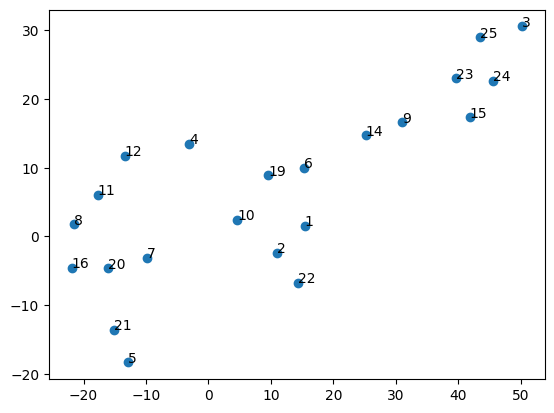

In [115]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df2 = df[~df.index.isin([i-1 for i in [13, 17, 18, 26]])]
run_tsne(df2[df2.columns[1:]].to_numpy(), labels=participants)

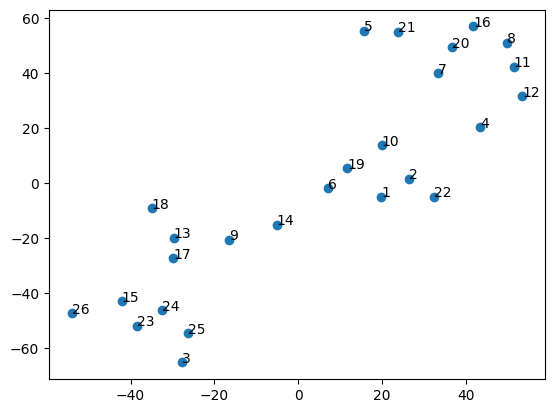

In [116]:
participants = list(range(1, 27))
run_tsne(df[df.columns[1:]].to_numpy(), labels=participants)

### With 4 point correlation

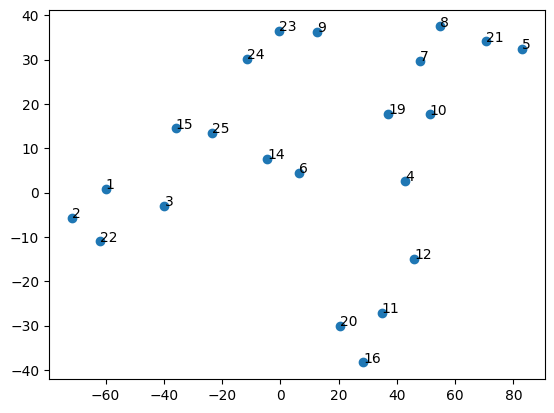

In [117]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df2 = df[~df.index.isin([i-1 for i in [13, 17, 18, 26]])]
run_tsne(df2.to_numpy(), labels=participants)

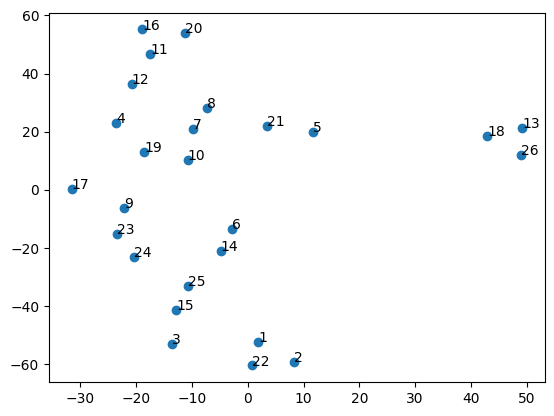

In [105]:
participants = list(range(1, 27))
run_tsne(df.to_numpy(), labels=participants)

## Repeat with Spearman

### Without 4 point correlation

In [125]:
df = pd.DataFrame(correlations['rsivl']['spearman_4points'])

for i in range(1, len(levels)):
    df["{}-{}".format(levels[i], levels[i-1])] = correlations['rsivl']['spearman_{}'.format(levels[i])]-correlations['rsivl']['spearman_{}'.format(levels[i-1])]

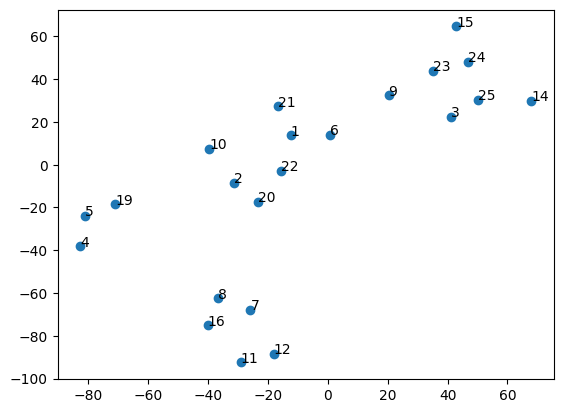

In [138]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df2 = df[~df.index.isin([i-1 for i in [13, 17, 18, 26]])]
run_tsne(df2[df2.columns[1:]].to_numpy(), labels=participants)

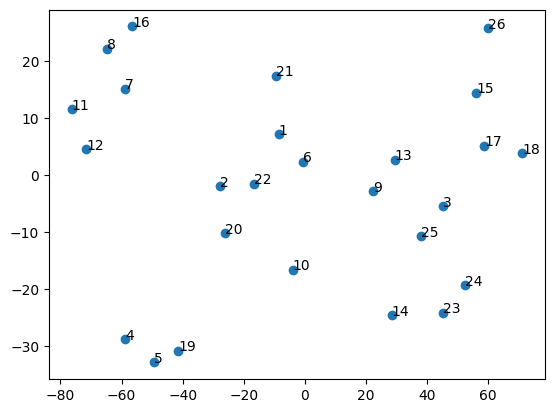

In [127]:
participants = list(range(1, 27))
run_tsne(df[df.columns[1:]].to_numpy(), labels=participants)

### With 4 point correlation

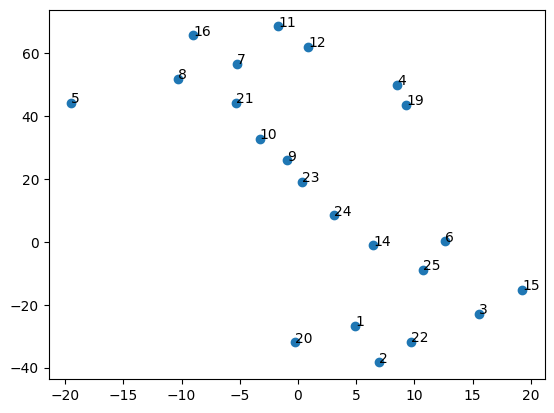

In [128]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
df2 = df[~df.index.isin([i-1 for i in [13, 17, 18, 26]])]
run_tsne(df2.to_numpy(), labels=participants)

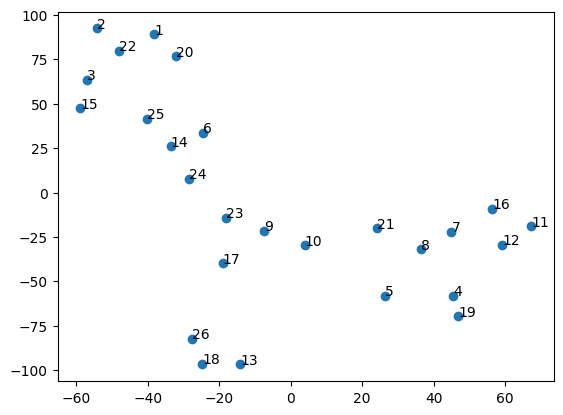

In [129]:
participants = list(range(1, 27))
run_tsne(df.to_numpy(), labels=participants)

# Clustering Participants based on Ratings

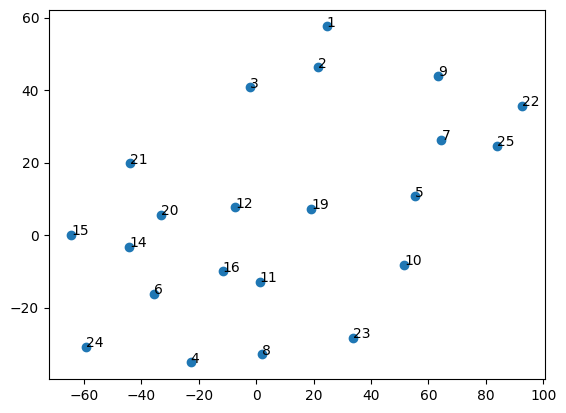

In [149]:
participants = list(range(1, 27))
participants = [x for x in participants if x not in [13, 17, 18, 26]]
X = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy().swapaxes(1, 0)
run_tsne(X, labels=participants)

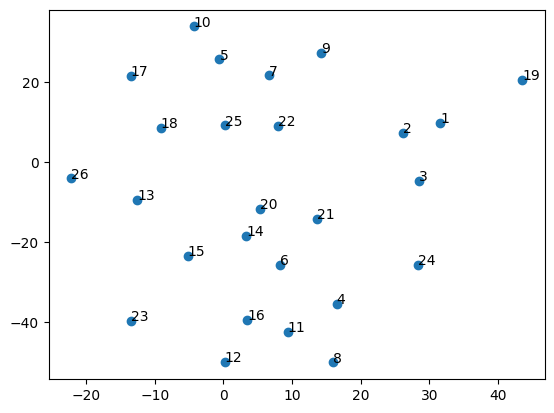

In [150]:
participants = list(range(1, 27))
X = data['rsivl'][["participant{}".format(i) for i in participants]].to_numpy().swapaxes(1, 0)
run_tsne(X, labels=participants)